# Загружаем Fast AI

Документация по фреймворку Fast AI по работе с текстом: https://docs.fast.ai/text.html

Импортируем необходимые модули

In [1]:
from pathlib import Path

In [2]:
from torch.nn import CrossEntropyLoss

In [3]:
import pandas as pd

In [4]:
from fastai.text.all import *

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
from tqdm import tqdm_notebook

# Подготавливаем данные

Сохраните данные для обучени и модели на свой Google-диск:
https://drive.google.com/drive/folders/1XdXiGQVa426zNEoG4ipgFbXWWxXGZQ0Y?usp=sharing


Монтируем Google Drive в Google Colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Проверяем, что на Google Drive появилась расшаренная папка `fast-ai-text`

In [7]:
! ls '/content/drive/My Drive/fast-ai-text'

max_bot  russian_lm


Копируем данные с Google диска на локальный диск виртуальной машины

In [8]:
! cp -rL '/content/drive/My Drive/fast-ai-text' ml 

Определяем корневой путь, с которым будем работать

In [9]:
ROOT_PATH = Path('/content/ml')

In [10]:
list(ROOT_PATH.iterdir())

[Path('/content/ml/russian_lm'), Path('/content/ml/max_bot')]

In [11]:
DATA_PATH = ROOT_PATH/'max_bot'/'data'

In [12]:
list(DATA_PATH.iterdir())

[Path('/content/ml/max_bot/data/max-messages.tsv'),
 Path('/content/ml/max_bot/data/max-sequences.tsv'),
 Path('/content/ml/max_bot/data/result.json')]

### Читаем данные отзывов с помощью Pandas

In [74]:
df_all = pd.read_csv(DATA_PATH/'max-sequences.tsv', sep='\t')

In [75]:
df_all.iloc[1000:1030]

,seq_id,target_text
1000,1035,"Вообще, надо у Сани спросить, у них там знаменитые пермские солеварни xxmessage xxmax ну да не зря же говорят Пермяк соленые ноздри xxmessage xxmax ой уши"
1001,1036,xxmax это восьмерка
1002,1037,"xxmax user_mention_tok а вот ты после пьянки никогда чтоли еду у себя в карманах не находил? xxmessage Нет xxmessage xxmax ну там спиженные мандарины например xxmessage Зачем класть еду в карманы? xxmessage xxmax ну а куда её класть когда она лежит и её надо взять? xxmessage xxmax не знаю я находил после бухича в детсве и сок из-под барной стойки телеклуба в рюкзаке и конфетки и фрукты всякие в карманах, даже виноград в карманах джинс бывал xxmessage xxmax и все это благодаря водочке) xxmessage xxmax водочка кормилица) xxmessage xxmax а вот сейчас не пью еды нет в карманах) xxmessage xxma..."
1003,1038,"xxmax как ты вообще бухаешь Коврига тогда? xxmessage xxmax нахуй тогда бухать, вот я не пью сейчас, худею"
1004,1039,"Пасхалочки от навигатора xxmessage xxmax даже не знаю что тут сказать\nА ты вообще в курсе что ты лесбиянка? xxmessage Да xxmessage Квир лесба в теле мужика xxmessage xxmax ковырни да подлижи xxmessage xxmax Ножницы есть? xxmessage Нет. И вообще, говорить я с тобой буду только после того, как ты назовешь все 1488 гендеров, установленных социологами xxmessage xxmax их 1408 xxmessage xxmax там надо час продержаться чтобы все узнать xxmessage Ты заблуждаешься xxmessage 80 гендеров протерял где-то xxmessage xxmax Я вообще человекоид что ты хочешь, при создании заложили 1408 гендеров, надо обн..."
1005,1040,"Ну, смотри, предложить, может и предложили, но, если ты помнишь, у нас пробовали лочить порносайты уже, и, как видишь, все работает) xxmessage xxmax в смысле работает?\nвсе же залочено xxmessage Ага-ага xxmessage Особенно, терабайиы порнухи в вк 😂 xxmessage И порнхаб xxmessage xxmax дак хаб не зайти из русии"
1006,1041,Зайти xxmessage Без регистрации и впн
1007,1042,"xxmax дак в смысле он не работает xxmessage xxmax это плохо для русского человека такое смотреть, потом молиться придется"
1008,1043,"xxmax нет подобного контента в России!\nосталось выпилить компьютерные игры и тогда заживем, без стрельбы а улицах и в муниципальных помещеиях"
1009,1044,"xxmax упс, я всегда непрезентабельный xxmessage xxmax как сдавать то ВКР xxmessage xxmax я же ненавижу костюмы из-за навязывания их в школе"


Размеры тренировочной и валидационной выборок

In [76]:
df_all.shape

(3582, 2)

# Языковая модель

## Подготовка данных

**BatchSize** - основной гиперпараметр сети, определяющий кол-во одновременно обрабатываемых обучающих примеров

In [18]:
bs = 32

Загружаем словарь

In [19]:
import pickle

In [94]:
ROOT_PATH

Path('/content/ml')

In [20]:
with open(ROOT_PATH/'russian_lm'/'models'/'itos.pkl', 'rb') as f:
  itos = pickle.load(f)

In [21]:
len(itos)

60004

In [ ]:
df_all.head()

,id,date,date_unixtime,target_text
0,-999984251,2018-01-31T05:58:54,1517374734,"Я вот не могу курить по пачке в день, но и бро..."
1,-999984249,2018-01-31T05:59:55,1517374795,"Если горло болит не курю, не приятно"
2,-999984244,2018-01-31T06:01:43,1517374903,Но вот на счет пользы беременным у меня возник...
3,-999984243,2018-01-31T06:02:31,1517374951,Таки дорого курить по пачке в день)
4,-999984240,2018-01-31T06:04:31,1517375071,Бросать вообще вредно


In [77]:
_re_maj = re.compile(r'(\s|^)([A-ZА-Я][^A-ZА-Я\s]*)(?=(\s|$))')

# Cell
def replace_maj_fixed(t):
    "Replace tokens in Sentence Case by their lower version and add `TK_MAJ` before."
    def _replace_maj(m):
        tok = f'{TK_MAJ} ' if len(m.groups()[1]) > 1 else ''
        return f"{m.groups()[0]}{tok}{m.groups()[1].lower()}"
    return _re_maj.sub(_replace_maj, t)

In [98]:
tokenizer = TokenizeWithRules(SpacyTokenizer(lang='ru'), [replace_maj_fixed, lowercase], [replace_space])

In [100]:
next(tokenizer(['Here is you и Ты sssss я я я я']))

(#13) ['xxbos','xxmaj','here','is','you','и','xxmaj','ты','sssss','я'...]

In [80]:
data = TextDataLoaders.from_df(df_all, text_col='target_text', is_lm=True, seed=42, valid_pcd=0.08, tok_tfm=tokenizer)

In [70]:
len(data.vocab)

6656

In [81]:
data.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'xxmessage']

In [87]:
remain_words = [x for x in itos if x not in data.vocab]

In [93]:
new_vocab = data.vocab + remain_words[:50000]

In [95]:
with open(ROOT_PATH/'max_bot'/'data'/'extended_vocab.pkl', 'wb') as f:
  pickle.dump(new_vocab, f)

In [96]:
data = TextDataLoaders.from_df(df_all, text_col='target_text', is_lm=True, seed=42, valid_pcd=0.08, tok_tfm=tokenizer, text_vocab=new_vocab)

In [97]:
data.show_batch()

,text,text_
0,"xxbos xxbos ну типо в какую можешь , в такую и xxunk . xxunk на xxup hh варианты xxbos xxbos какая xxunk ) xxmessage я бы xxunk ) xxbos xxbos xxmax ты итальянское безумие подхватил ? ) xxmessage xxmax ты скоро начнешь говорить вот так xxunk xxmessage xxmax я изучал итальянский язык я знаю ) xxmessage xxmax если честно с xxunk по xxunk много ебали xxmessage xxmax лучше всего смотреть на xxunk","xxbos ну типо в какую можешь , в такую и xxunk . xxunk на xxup hh варианты xxbos xxbos какая xxunk ) xxmessage я бы xxunk ) xxbos xxbos xxmax ты итальянское безумие подхватил ? ) xxmessage xxmax ты скоро начнешь говорить вот так xxunk xxmessage xxmax я изучал итальянский язык я знаю ) xxmessage xxmax если честно с xxunk по xxunk много ебали xxmessage xxmax лучше всего смотреть на xxunk или"
1,". остановил вторжение xxunk в 2009 . xxunk факт . xxbos xxbos да чот работы до xxunk матери , вот и xxunk ) ) xxbos xxbos забавно что ркн xxunk даже не из пушки , а ракетами по телеге , а им хоть бы хуй xxmessage представить боюсь какой бугурт у жарова это вызывает xxmessage ну , такое себе похуй , на самом деле ) xxmessage xxunk - то xxunk xxmessage я","остановил вторжение xxunk в 2009 . xxunk факт . xxbos xxbos да чот работы до xxunk матери , вот и xxunk ) ) xxbos xxbos забавно что ркн xxunk даже не из пушки , а ракетами по телеге , а им хоть бы хуй xxmessage представить боюсь какой бугурт у жарова это вызывает xxmessage ну , такое себе похуй , на самом деле ) xxmessage xxunk - то xxunk xxmessage я думаю"
2,"высшего образования , оно меня не интересует ни в каком виде , есть ряд специальностей , для которых оно необходимо , в эти специальности я идти не планирую , а все нужные навыки для текущей работы я могу получить сам , не xxunk 5 лет с xxunk xxunk xxunk xxmessage xxmax да я боюсь тебе уже не попасть на учебу xxmessage ты даже не можешь себе представить , как же мне похуй","образования , оно меня не интересует ни в каком виде , есть ряд специальностей , для которых оно необходимо , в эти специальности я идти не планирую , а все нужные навыки для текущей работы я могу получить сам , не xxunk 5 лет с xxunk xxunk xxunk xxmessage xxmax да я боюсь тебе уже не попасть на учебу xxmessage ты даже не можешь себе представить , как же мне похуй )"
3,"xxmax я делаю поддержку которую на меня назначили xxmessage я работал за копейки с огромной xxunk xxmessage xxmax остальные делают проекты за доп . бабки xxmessage xxmax ну вот , в xxunk так xxmessage xxmax меня туда звали , я отказался xxmessage xxmax то место где я типа практику проходил xxmessage xxmax но там правда отстой , делать нечего с ума сходишь от xxunk и зп задерживают по 2 месяца xxmessage xxmax","я делаю поддержку которую на меня назначили xxmessage я работал за копейки с огромной xxunk xxmessage xxmax остальные делают проекты за доп . бабки xxmessage xxmax ну вот , в xxunk так xxmessage xxmax меня туда звали , я отказался xxmessage xxmax то место где я типа практику проходил xxmessage xxmax но там правда отстой , делать нечего с ума сходишь от xxunk и зп задерживают по 2 месяца xxmessage xxmax я"
4,"и бафет xxmessage xxmax и кофе определенно мой брат которого я не знаю делал ) xxmessage xxmax какой - то другой иисус xxbos xxbos ты типичный чувак , родившийся во времена xxunk \n @ \n любишь рэп , баскетбол , и ещё воду \n @ \n переехал из солнечного города на западное побережье \n @ \n живешь там и xxunk \n @ \n казалось бы # xxunk \n @ \n но xxunk","бафет xxmessage xxmax и кофе определенно мой брат которого я не знаю делал ) xxmessage xxmax какой - то другой иисус xxbos xxbos ты типичный чувак , родившийся во времена xxunk \n @ \n любишь рэп , баскетбол , и ещё воду \n @ \n переехал из солнечного города на западное побережье \n @ \n живешь там и xxunk \n @ \n казалось бы # xxunk \n @ \n но xxunk xxunk"
5,"что китайцы и на xxunk xxunk xxbos xxbos ну , хорошо , я с xxunk буду выезжать часов в 10 xxmessage xxmax давай xxmessage xxmax xxunk с xxunk захвати ) xxmessage xxmax прям на

In [101]:
len(data.vocab)

56656

In [ ]:
# data = TextList.from_df(df_all, cols='target_text',
#                         processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
#                                    NumericalizeProcessor(vocab=vocab)]).\
#                 split_from_df('valid').\
#                 label_for_lm().\
#                 databunch(bs=bs)

NameError: ignored

Сохраняем данные для того, чтобы в следующий раз не приходилось заново обрабатывать текст

In [ ]:
# data.save(DATA_PATH / "kinopoisk_lm_data.pkl")

In [ ]:
data = load_data(DATA_PATH, "kinopoisk_lm_data.pkl", bs)

### Посмотрим как выглядят данные

In [ ]:
data.show_batch()

Каждому слову (токену) ставится в соответствии порядковый номер из словаря

In [ ]:
data.vocab.itos[:17]

xxunk, xxpad и тд - это специальные токены, для представления текста.
Например, токен **xxmaj** показывает, что следующее слово в исходном тексте начинается с большой буквы.

Каждому токену соответсвует число из словаря:

Задача нейронной сети при обучении языковой модели - предсказать наиболее вероятное слово, идущее после данной последовательности слов.

## Обучение модели

Используемая архитектура сети - реализация [AWD-LSTM](https://arxiv.org/abs/1708.02182) (Average SGD Weights Dropped LSTM)

*Если мы обрабатываем тексты на английском языке, то Fast AI имеет предобученную на Википедии модель*

In [ ]:
# learn = language_model_learner(
#     data, AWD_LSTM, drop_mult=0.3, 
#     metrics=[accuracy, Perplexity()]).to_fp16()

Мы воспользуемся предобученной моделью на корпусе текстов "Тайга".

Веса модели взяты взята отсюда: https://github.com/mamamot/Russian-ULMFit

Корпус текстов Тайга: https://tatianashavrina.github.io/taiga_site/

**Дополнительно**

Как обучить языковую модель на википедии: https://github.com/ademyanchuk/ulmfit-multilingual

Обсуждение темы на форуме Fast AI: https://forums.fast.ai/t/ulmfit-russian/36312



*Так как настройки нашей предобученной модели отличаются от дефолтных - мы определим их сами явно*

In [102]:
awd_lstm_lm_config_old = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=1, bidir=False, output_p=0.1,
                          hidden_p=0.15, input_p=0.25, embed_p=0.02, weight_p=0.2, tie_weights=True, out_bias=True)
awd_lstm_clas_config_old = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=1, bidir=False, output_p=0.4,
                            hidden_p=0.3, input_p=0.4, embed_p=0.05, weight_p=0.5)

In [103]:
learn = language_model_learner(data, arch=AWD_LSTM, config=awd_lstm_lm_config_old,
                               pretrained_fnames=('lm_5_ep_lr2-3_5_stlr', 'itos'),
                               metrics=[accuracy, Perplexity()], 
                               path=ROOT_PATH/'russian_lm',
                               pretrained=False)
# learn.loss_func = CrossEntropyFlat()

Проверим, как работает модель

In [104]:
TEXT = "Британские ученые обнаружили"
N_WORDS = 60
N_SENTENCES = 2

In [105]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.7) for _ in range(N_SENTENCES)))

британские ученые обнаружили в Северной Африке новую партию из 30 тысяч ДНК , которые показывают , что у них находится образец , в котором могут находиться найденные в будущем для повторного захоронения . Как сообщает Reuters , об этом сообщили представители Human Rights Watch . По словам ученых , это означает , что в
британские ученые обнаружили в Центральной Америке , Канаде , Швейцарии и Южной Америке землетрясение магнитудой 5,5 , сообщает AFP . Эпицентр располагался недалеко от города Ла - Сан - Франциско . Подземные толчки были зафиксированы в в 9 часов утра по местному времени ( 10:00 по московскому ) . Эпицентр


In [ ]:
TEXT = "Макс пошел"
N_WORDS = 60
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

макс xxunk иди нахуй ! ты про мой бункер , которого я не любил ? ну а откуда у тебя есть по - то где - то в больницу ? ну я на 30 минут понял что я как бы не ебу ) ну как у тебя получится ? видимо в поддержка только тех и не только
макс xxunk , я конечно не хочу начинать с этого так что ты сам придумал , что если ты не можешь к ним собраться , то тебе не давали возможность на мою работу наверное я бы сказал что мое место принадлежит другому человеку конечно , мне интересно , что такое надо делать , а не то что смотреть


In [ ]:
# Введите текст:
TEXT = ""
N_WORDS = 60
N_SENTENCES = 2

### Поиск оптимального шага обучения

Перед тем как приступить к обучению языковой модели, мы должно найти оптимальный learning_rate (lr) - это гиперпараметр, который определяет с какой скоростью будет обучаться модель

SuggestedLRs(valley=0.010964781977236271)

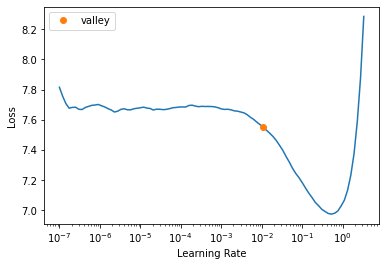

In [106]:
learn.lr_find()

На графике нам нужно выбрать наибольший LR такой, что Loss (функцию потерь) еще достаточно быстро уменьшается. Мы выберем 10e-2. 

In [108]:
lr = 2e-2

Посмотрим из каких слоев состоит нейронная сеть

In [ ]:
learn.model

In [ ]:
learn.summary()

### ВНИМАНИЕ!!! Обучение языковой модели занимает часы! Не делайте этого на воркшопе

Так как часть слов в словаре новые и сеть про них ничего не знает, то мы начнем обучать только последний слой и embedding-и новых слов

In [110]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.756323,5.027802,0.207255,152.597229,00:28


In [111]:
learn.save('1epoch')

Path('/content/ml/russian_lm/models/1epoch.pth')

In [112]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.961422,4.904604,0.222172,134.909531,00:27
1,4.766666,4.801419,0.232492,121.682938,00:26
2,4.492002,4.770394,0.238291,117.965691,00:26
3,4.264929,4.760892,0.238805,116.850159,00:26


Сохраняем модель

In [113]:
learn.save('max_bot_head')

Path('/content/ml/russian_lm/models/max_bot_head.pth')

In [ ]:
learn.load('max_bot_head')

Теперь мы "размораживаем" все слои и продолжим обучение языковой модели

In [114]:
learn.unfreeze()

In [115]:
learn.fit_one_cycle(1, lr/4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.061714,4.782299,0.240128,119.378433,00:30


In [116]:
learn.fit_one_cycle(8, 5e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.789494,4.820476,0.238555,124.024117,00:31
1,3.826562,4.893200,0.228432,133.379761,00:31
2,3.750602,4.857192,0.238615,128.662415,00:29
3,3.571283,4.966880,0.232632,143.578262,00:29
4,3.334290,5.056672,0.238785,157.066940,00:30
5,3.118974,5.134929,0.238161,169.852203,00:29
6,2.910733,5.177786,0.239697,177.289841,00:29
7,2.781032,5.201084,0.239006,181.468781,00:29


In [117]:
learn.save('max_bot_tuned')

Path('/content/ml/russian_lm/models/max_bot_tuned.pth')

In [ ]:
learn.load('max_bot_tuned');

Качество языковой модели измеряется такой метрикой, как перплексия. В данном случае ее можно посчитать, если взять экспоненту от величины функции потерь на валидационной выборке. Чем меньше перплексия, тем лучше

In [ ]:
np.exp(4.403839)

81.76415952681097

#### Сохраняем Encoder

In [118]:
learn.save_encoder('max_bot_tuned_enc')

In [125]:
TEXT = "А речь шла именно о входящих переводах? xxmesage xxmax"
N_WORDS = 20
N_SENTENCES = 10

In [128]:
len('а речь шла именно о входящих xxunk ? xxunk xxmax')

48

In [129]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.7)[47:] for _ in range(N_SENTENCES)))

x ну типа я думаю что это как бы должно быть в карман штанов ) xxmax ну что сказать
x ну ладно с этого момента я каждый день объясню тп мне так и говорю что все знают что у меня
x user_mention_tok ты тут ? xxmessage xxmax у меня встал вопрос ! 
 а ты почему ? xxmessage xxmax ты не
x есть в россии дохуя мессенджеров , там довольно все же работают … xxmax user_mention_tok у меня встал вопрос
x ну ладно , у нас тоже работает в нерабочее время , да и похуй xxmessage xxmax это уже перебор xxmessage
x ну типа это просто не транс xxmessage xxmax ну по крайней мере у меня на работе не висит крысы xxmessage
x там ещё летал )))) xxmessagexxmessagexxmessagexxmessage xxmaxxxmaxxxmaxxxmax уууу тебятебятебятебя будетбудетбудетбудет шансшансшансшанс нананана этоэтоэтоэто ???? )))) xxmessagexxmessagexxmessagexxmessage xxmaxxxmaxxxmaxxxmax простопростопростопросто еслиеслиеслиесли
x ну точнее в одно и то же xxmax user_mention_tok 
 ты знаешь ? xxmessage xxmax а то я
x кто ? xxmessage xxmax я знаю что т

In [119]:
! cp /content/ml/russian_lm/models/max_bot_tuned.pth /content/drive/MyDrive/fast-ai-text/max_bot/new_models/max_bot_tuned.pth

In [120]:
! cp /content/ml/russian_lm/models/max_bot_tuned_enc.pth /content/drive/MyDrive/fast-ai-text/max_bot/new_models/max_bot_tuned_enc.pth

In [121]:
with open('max_bot_vocab.pkl', 'wb') as f:
  pickle.dump(data.vocab, f)

In [122]:
! cp max_bot_vocab.pkl /content/drive/MyDrive/fast-ai-text/max_bot/new_models/max_bot_lm_vocab.pkl

## Загружаем модель для выполнения

In [ ]:
! ls ml/max_bot

data  models


In [ ]:
awd_lstm_lm_config_old = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=1, bidir=False, output_p=0.1,
                              hidden_p=0.15, input_p=0.25, embed_p=0.02, weight_p=0.2, tie_weights=True, out_bias=True)

In [ ]:
MAX_BOT_PATH = ROOT_PATH/'max_bot'

In [ ]:
with open(MAX_BOT_PATH/'models'/'max_bot_lm_vocab.pkl', 'rb') as f:
  vocab = pickle.load(f) 

In [ ]:
len(vocab)

3808

In [ ]:
model = get_language_model(AWD_LSTM, len(vocab), config=awd_lstm_lm_config_old, drop_mult=1.0)

In [ ]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(3808, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(3808, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=3808, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
default_device()

device(type='cuda', index=0)

In [ ]:
data.test_dl()

<bound method DataLoaders.test_dl of <fastai.data.core.DataLoaders object at 0x7fd0b05b66d0>>

In [ ]:
tok = SpacyTokenizer(lang='ru')
# idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
text_block = TextBlock(tok, vocab=vocab, is_lm=True, seq_len=72)
data_block = DataBlock([text_block])

In [ ]:
data_block.dataloaders('.')

TypeError: ignored

In [ ]:
text_block.batch_tfms(['У меня встал вопрос'])

TypeError: ignored

In [ ]:
class LMPridicted(TextLearner):
    "Add functionality to `TextLearner` when dealing with a language model"
    def predict(self, text, vocab, n_words=1, no_unk=True, temperature=1., min_p=None, no_bar=False,
                decoder=decode_spec_tokens, only_last_word=False, device=None, seq_len=72):
        "Return `text` and the `n_words` that come after"
        self.model.reset()
        tok = SpacyTokenizer(lang='ru')
        # idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
        blocks = [TextBlock(tok, vocab=vocab, is_lm=True, seq_len=seq_len)]
        dblock = DataBlock(blocks=blocks,
                           get_items=noop,
                          #  splitter=splitter,
                          #  get_y=None
                           )
        dls = TextDataLoaders.from_dblock(dblock, '.')
        idxs = idxs_all = dls.test_dl([text]).items[0].to(device or default_device())
        if no_unk: unk_idx = vocab.index(UNK)
        for _ in (range(n_words) if no_bar else progress_bar(range(n_words), leave=False)):
            with self.no_bar(): preds,_ = self.get_preds(dl=[(idxs[None],)])
            res = preds[0][-1]
            if no_unk: res[unk_idx] = 0.
            if min_p is not None:
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
            if only_last_word: idxs = idxs[-1][None]

        # num = self.dls.train_ds.numericalize
        # num = Numericalize(vocab=vocab)
        tokens = [vocab[i] for i in idxs_all if vocab[i] not in [BOS, PAD]]
        # sep = self.dls.train_ds.tokenizer.sep
        sep = tok.sep
        return sep.join(decoder(tokens))

    @delegates(Learner.get_preds)
    def get_preds(self, concat_dim=1, **kwargs): return super().get_preds(concat_dim=1, **kwargs)

In [ ]:
learn = LMPridicted(None, model, loss_func=CrossEntropyLossFlat())

In [ ]:
TEXT = "У меня встал"
N_WORDS = 60
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, vocab, N_WORDS, temperature=0.5) for _ in range(N_SENTENCES)))

TypeError: ignored

In [ ]:
test_df = pd.DataFrame({'text': 'у меня встал вопрос'.split()})

In [ ]:
test_df

,text
0,у
1,меня
2,встал
3,вопрос


In [ ]:
test_data = TextDataLoaders.from_df(test_df, is_lm=True, seed=42, valid_pcd=0.25)

In [ ]:
learn = language_model_learner(test_data, arch=AWD_LSTM,
                              config=awd_lstm_lm_config_old,
                              pretrained=False,
                              pretrained_fnames=('max_bot_tuned', 'max_bot_lm_vocab'),
                              path= MAX_BOT_PATH)

In [ ]:
TEXT = "У меня встал"
N_WORDS = 60
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, vocab, N_WORDS, temperature=0.5) for _ in range(N_SENTENCES)))

TypeError: ignored

## Загружаем предобученную модель

А теперь загрузим уже обученную на отзывах модель и поэкспериментируем с ней

In [ ]:
learn = language_model_learner(data, arch=AWD_LSTM,
                               config=awd_lstm_lm_config_old,
                               pretrained=False, 
                               pretrained_fnames=('kinopoisk_tuned', 'kinopoisk_lm_vocab'),
                               path=ROOT_PATH/'kinopoisk')

Посмотрим как работает предсказание

In [ ]:
TEXT = "полный эффект присутствия"
N_WORDS = 60
N_SENTENCES = 2

print(u"\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [ ]:
TEXT = "Мрачный, жестокий фильм с"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [ ]:
TEXT = "На самом деле в этом"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [ ]:
TEXT = "могло быть и"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [ ]:
TEXT = "самый настоящий провал"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

# Классификация отзывов с Кинопоиска

## Подготовка данных

In [ ]:
bs = 48


Важно, чтобы словарь, используемый для классификатора, 
в точности **совпадал со словарем**, который использовалася на этапе обучения **языковой модели**

In [ ]:
vocab = Vocab.load(ROOT_PATH/'kinopoisk'/'models'/'kinopoisk_lm_vocab.pkl')

In [ ]:
# если у вас уже загрузены данные языковой модели, то можно сделать
# vocab = data.vocab

In [ ]:
data_clas = (TextList.from_df(df_all, cols='reviewBody', vocab=vocab)
             .split_from_df('valid')
             .label_from_df(cols='status')
             .databunch(bs=bs))

In [ ]:
# data_clas.save(DATA_PATH/'kinopoisk_clas_data.pkl')

In [ ]:
data_clas = load_data(DATA_PATH, "kinopoisk_clas_data.pkl", bs=bs)

А теперь создадим классификатор

In [ ]:
learn = text_classifier_learner(data_clas, 
                                arch=AWD_LSTM,
                                config=awd_lstm_clas_config_old,
                                drop_mult=0.5, 
                                path=ROOT_PATH/'kinopoisk',
                                pretrained=False)
# Загружаем предварительно обученный encoder
learn.load_encoder('kinopoisk_tuned_enc');

## Обучаем классификатор

Пожалуйста, найдите оптимальный learning rate и обучите модель одну эпоху c этим learning rate, как это делалось для языковой модели. Укажите параметр `moms=(0.8, 0.7)`

Сохраните полученную модель под именем `kp_first`

А теперь мы продолжаем размораживать слои, обучая их "по очереди", начиная с конца.

Мы не хотим сразу разрушить хрупкую структуру Encoder-a, который был обучен на предыдущем шаге.

Сохраните обученную модель с именем `kp_second`

### На досуге можно продолжить обучать модель, размораживая следующие слои

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.141272,0.106738,0.960053,06:24


In [ ]:
learn.save('kp_third')

In [ ]:
learn.load('kp_third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
# Дальше возникает переобучение

Мы натренировали нашу сеть, которая **с высокой точностью (96%)** определяет "тональность" отзыва

### Загрузим уже обученный заранее классификатор

In [ ]:
learn.load('kinopoisk_clas_tuned');

Давайте проверим ее на случайном отызыве с кинопоиска

In [ ]:
# Пример положительного отзыва

learn.predict('''
«Балканский рубеж» в некотором роде уникальный фильм для нашего синематографа последнего времени. И вот почему, с одной стороны мы снимаем по лекалам телефильмов о доблестном спецназе кино, которое при прочих равных прошло бы более или менее не замеченным, а с другой стороны обозначаем проблему сосуществования народов и этнических войн на территории бывшей Югославии. К данной теме я вообще не равнодушен и было интересно взглянуть, как отечественный режиссер покажет эти моменты. И получилось совсем не плохо, по крайней мере, у меня не возникает чувства непонимания, что происходило в Боснии и Косово. Да, широкими мазками обозначена проблема, зато доходчиво донесено, что испытывали простые люди при развале страны. 

После конфликта во взаимодействии с силами НАТО, члены разведовательно — диверсионной группы оказываются в непростой ситуации и вынуждены остаться вне пределов России. Каждый устраивается по своему в новой жизни и старается выжить. Но изменение вектора политической обстановки вновь делает их востребованными Отечеством. Надо занять и удержать аэропорт Приштины в Косово, до подхода российских миротворцев. Захват и удержание показаны в добротной манере отечественных сериалов, останавливаться на этом не буду, меня больше порадовали второстепенные линии сюжета. Возможно, сотрудничество с сербами сделали эти линии проникновенными с чисто человеческого восприятия. Это и драма в роддоме при налетах НАТО, и непростые отношения косоваров и сербов на примере полицейского поста в Косово, и этническо — конфессиональные расстрелы, и напряжение до срывов медработников от вида пострадавших — говорят война все спишет, это так. Только вот рубцов и ран в душах людей не излечит даже время, боль и горечь потерь близких и друзей долго будет жить в памяти. 

Переплетение реальных фактов и художественного вымысла неплохо сочеталось в этой ленте — марш-бросок на Приштину десантников удачно дополнил бой группы Бека, восторги сербов на кадрах хроники и киношные смотрелись органично. Что касается политических перипетий, то это дело грязное и идеологический контекст можно и пропустить при просмотре, хотя ничего нереального в показанном я не увидел. Порадовали показанные будни десантников, под «Сектор газа» смотрелось реалистично, вполне реальное развлечение для отвлечения от повседневной рутины.

Актеры сыграли в целом нормально и наши и сербские, из наших мне понравились Куркова, Полухин и Марин, из сербов Гойко Митич, Бикович и Родойичич. Специфический юмор только усилил игру актеров. Кустурица в концовке тоже смотрелся к месту. В целом, не проявив чудес актерского мастерства все смотрелись не плохо. 

Минусы конечно есть и довольно жирные, в основном связаны с навязыванием определенного идеологического подтекста, и увы, незнанием особенностей службы в войсках специального назначения. Но в целом фильм они не уродуют, поэтому смело отношу его к положительным моментам нашего кинопроката.
''')

In [ ]:
# Пример отрицательного отзыва

learn.predict('''
Пусть видят, кто против них (с)

В конце 90-ых, во время очередного конфликта между сербами и албанцами, российская спецгруппа, находящаяся на территории Югославии, получает приказ захватить местный аэропорт и удержать его до прихода наших миротворцев.

Режиссер «Танцев насмерть» и «Спирали», посредственных, никому ненужных картин, Андрей Волгин на западе давно бы оказался у разбитого корыта и пошел бы на прорыв, получив последний шанс или вошел бы в какую-нибудь когорту создателей сериалов, где ты просто один из тех, кто визуализирует чужие идеи. У нас же все совершенно по-другому произошло… Волгин получил большой бюджет, материал и не самых последних актеров, и что же он из этого смастерил? Все самое наипростейшее… Мотивы героев, как и предсказуемость сюжетных ходов и выпрыгивания спецэффектов из-за ушла — все это уже миллион раз использованные другими ходы, причем и реализованные сверхстандартно и стерильно. Ведь если у тебя есть антагонист, то кроме как дать ему нож и возможность оправдать рейтинг 16+ — единственный вариант продемонстрировать его характер и жестокость. Так же и с другими героями, один поет, другой постоянно про пенсию говорит, третий хочет денег, а узбечка заглянула на проект в поисках мужика, так и работают. А зрителям еще нужно разбираться причем тут НАТО, кто виноват и что делать, в общем не считая плохих дорог здесь есть все классические вопросы, волнующие русских на протяжении веков.

По какой-то совершенно непонятной причине главную роль в «Балканском рубеже» исполнил Антон Пампушный («Защитники») — парень, конечно, колоритный, но с одной эмоцией на лице на любое происшествие и действие в его (их) сторону. Странно видеть таким потерянным Милоша Биковича («Лед»), у него здесь ключевая драматическая роль, но он так все это преподносит, что хочется снять ему скальп ничуть не меньше, чем террористам, которые гоняются за ним. Красивую Милену Радулович («Однажды летней ночью») при любой возможности раздевают, а героиня Равшаны Курковой («Без границ») получилась не только крутой, но еще и с юморком. Одного из самых запоминающихся бойцов с нашей стороны сыграл Сергей Марин («Анна-детективъ»), его неоднозначности и крутости, могли бы позавидовать и заграничные коллеги. Для увесистости в фильм влились: Гоша Куценко («Параграф 78»), которому очень нравится собирать себе отряды, любимейший югослав старшего поколения Гойко Митич («Апачи») и вечный Эмир Кустурица («Время цыган»). 

Картина «Балканских рубеж» очевидно снята явно из хороших побуждений и желания сделать, что-то свое на уровне Бэя и его «13 часов». Главные герои — такие наши Джеймсы Бонды без фантастической составляющей. Но вот снят «Балканский рубеж» самым скучным и потребительским образом: с кучей слоу-мо, увидев его количество даже создатели «Т-34» тихо стоят и покуривать в сторонке, хотя попытку сыграть в масштаб и серьезность можно и зачесть. Правда дешевые спецэффекты и длиннющие диалоги с попыткой хоть как-то раскрыть героев портят этот и так слишком затянутый фильм с нелогичным кастингом и музыкой, которая убаюкивает зрителей постоянно повторяющимся мотивом.''')

In [ ]:
learn.predict('Очень хороший фильм')

In [ ]:
learn.predict('Почему то мне кажется, что фильм далек от идеала. Я бы не советовал его смотреть')

In [ ]:
learn.predict('''
              Фильм показался мне ужасным.
              Это невероятное чувство плохой игры актеров.
              Не рекомендую смотреть
              ''')

Экспериментируйте!

In [ ]:
learn.predict("Лучший фильм, который я когда-либо смотрел!")

In [ ]:
learn.predict("Это худший фильм, который я когда-либо смотрел. Такие дела. Хотя может быть и стоит посмотреть фанатам")

## Интерпритируем результаты работы

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

Пары классов, которые сеть путает больше всего

In [ ]:
interp.most_confused()

Посмотрим на матрицу ошибок:

In [ ]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=80)

In [ ]:
learn.predict('Это ужасный фильм. И как это я мог такое смотреть? Крайне не рекомендую')